# **El algoritmo es correcton't - Wide and Deep Neural Network**
---

Red neuronal con carácterísticas polinómicas para variables numéricas (grado 2, sólo interacciones). Y modelo lineal para variables booleanas.

Se combinan en la salida de manera que las caracteristicas booleanas se concatenan con las caracteristicas extraidas por la red neuronal para calcular la salida.

## **Montar Google Drive**
---



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive
!ls Shareddrives

/gdrive
'El algoritmo es correcto (sale mal)'


In [3]:
import os

path = os.path.join('Shareddrives', 'El algoritmo es correcto (sale mal)')

%cd {path}

/gdrive/Shareddrives/El algoritmo es correcto (sale mal)


In [4]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 1.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Cargar y Preparar Datos
---



In [5]:
import pandas as pd

train_data = pd.read_csv('train_clean_v3.csv',index_col='id')

test_data = pd.read_csv('test_clean_v3.csv', index_col='id')
test_data.drop(columns=['vista', 'piso', 'valoradministracion'], inplace=True, errors='ignore')

In [6]:
train_data = train_data[(train_data['conjuntocerrado']==0) & (train_data['tipoinmueble_Casa']==1)]
train_data.drop(columns=['conjuntocerrado', 'tipoinmueble_Casa', 'tipoinmueble_Apartamento', 'localidad.1'], inplace=True, errors='ignore')
test_data.drop(columns=['conjuntocerrado', 'tipoinmueble_Casa', 'tipoinmueble_Apartamento', 'localidad.1', 'NOMBRE'], inplace=True, errors='ignore')

In [7]:
train_dummy = train_data.copy()
test_dummy = test_data.copy()

data = pd.concat([train_dummy, test_dummy], axis=0)

for col in data.columns:
    if data[col].dtype == object:
        dummies = pd.get_dummies(data[col], prefix=col)
        data.drop(columns=[col], inplace=True, errors='ignore')
        data = pd.merge(data, dummies, left_index=True, right_index=True)

train_dummy = data.iloc[:train_dummy.shape[0],:]
test_dummy = data.iloc[-test_dummy.shape[0]:,:]

In [8]:
binary_features = []
numerical_features = []

for feature, n in zip(train_dummy.columns, train_dummy.nunique()):
    if n <= 2: 
        binary_features.append(feature)
    else: 
        numerical_features.append(feature)

In [9]:
import numpy as np

train_numerical = train_dummy[numerical_features]
train_binary = train_dummy[binary_features]

test_numerical = test_dummy[numerical_features]
test_binary = test_dummy[binary_features]

In [17]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

SCALE_OUTPUT = False

# valoventa/area reducido 5% para variable a predecir
y_train = (train_dummy['valorventa'] / train_dummy['area']).values * 0.95
y_train= np.nanmean([y_train,train_dummy['valor_ref']], axis=0)

X_train_num = train_numerical.values[:,:-1]
X_train_bool = train_binary.values

y_test = (test_dummy['valorventa'] / test_dummy['area']).values * 0.95
y_test= np.nanmean([y_test, test_dummy['valor_ref']], axis=0)

X_test_num = test_numerical.values[:,:-1]
X_test_bool = test_binary.values

# transformers
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# transform train data
X_train_num = poly.fit_transform(X_train_num)
X_train_num = scaler_x.fit_transform(X_train_num)
if SCALE_OUTPUT:
    y_train = scaler_y.fit_transform(y_train.reshape((-1,1)))

# transform test data
X_test_num = poly.transform(X_test_num)
X_test_num = scaler_x.transform(X_test_num)
if SCALE_OUTPUT:
    y_test = scaler_y.transform(y_test.reshape((-1,1)))

# Print shapes
print("X_train_num \t", X_train_num.shape)
print("X_train_bool \t", X_train_bool.shape)
print("y_train \t", y_train.shape)

print("X_test_num \t", X_test_num.shape)
print("X_test_bool \t", X_test_bool.shape)
print("y_test  \t", y_test.shape)

X_train_num 	 (42696, 36)
X_train_bool 	 (42696, 50)
y_train 	 (42696,)
X_test_num 	 (53, 36)
X_test_bool 	 (53, 50)
y_test  	 (53,)


In [18]:
NUMERICAL_FEATURES = X_train_num.shape[1]
BOOLEAN_FEATURES = X_train_bool.shape[1]

print(NUMERICAL_FEATURES, BOOLEAN_FEATURES)

36 50


## **Definición del Modelo**
---

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.utils import plot_model

# custom Huber loss
def my_huber_loss(y_true, y_pred):
    threshold = 1
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss)

# inherit from the Model base class
def get_model():
    input_num = Input(shape=[NUMERICAL_FEATURES,], name='Numerical inputs')
    input_bool = Input(shape=[BOOLEAN_FEATURES,], name='Boolean inputs')
    x_num = Dense(128, activation='relu', name='Hidden_1')(input_num)
    x_num = Dense(64, activation='relu', name='Hidden_2')(x_num)
    x = concatenate([x_num, input_bool], name='Concat')
    out = Dense(1, activation=None, name='Regression_out')(x)
        
    return Model(inputs=[input_num, input_bool], outputs=[out], name='Wide_and_Deep_Model')

Model: "Wide_and_Deep_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Numerical inputs (InputLayer)   [(None, 36)]         0                                            
__________________________________________________________________________________________________
Hidden_1 (Dense)                (None, 128)          4736        Numerical inputs[0][0]           
__________________________________________________________________________________________________
Hidden_2 (Dense)                (None, 64)           8256        Hidden_1[0][0]                   
__________________________________________________________________________________________________
Boolean inputs (InputLayer)     [(None, 50)]         0                                            
________________________________________________________________________________

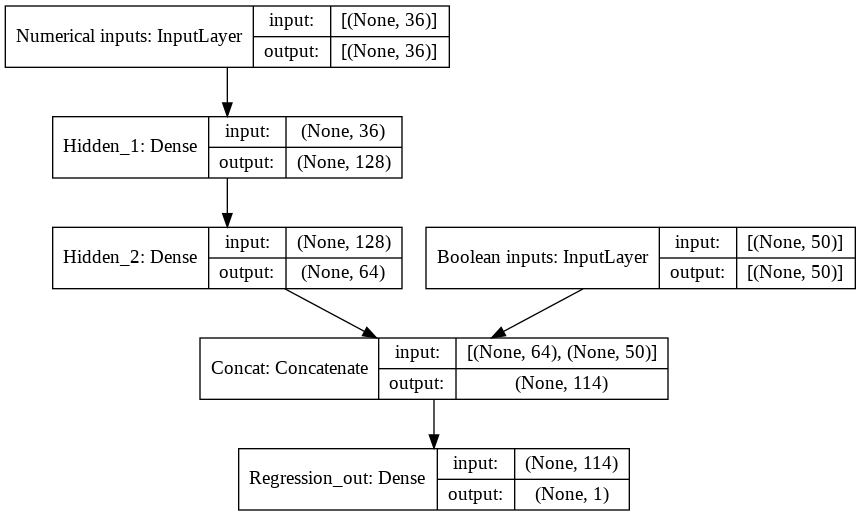

In [20]:
model = get_model()

model.summary()

plot_model(model, show_shapes=True)

In [21]:
model.compile(loss=tf.keras.losses.mean_absolute_percentage_error,
              optimizer=tf.keras.optimizers.Adam()
             )

history = model.fit([X_train_num, X_train_bool], y_train, 
                    epochs=2000,
                    batch_size=1024,
                    validation_data=([X_test_num, X_test_bool], y_test))

Epoch 1/2000
42/42 [==============================] - 1s 6ms/step - loss: 100.0000 - val_loss: 99.9999
Epoch 2/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.9997 - val_loss: 99.9994
Epoch 3/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.9983 - val_loss: 99.9969
Epoch 4/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.9920 - val_loss: 99.9893
Epoch 5/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.9760 - val_loss: 99.9729
Epoch 6/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.9440 - val_loss: 99.9436
Epoch 7/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.8842 - val_loss: 99.8989
Epoch 8/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.8127 - val_loss: 99.8355
Epoch 9/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.7034 - val_loss: 99.7488
Epoch 10/2000
42/42 [==============================] - 0s 3ms/step - loss: 99.555

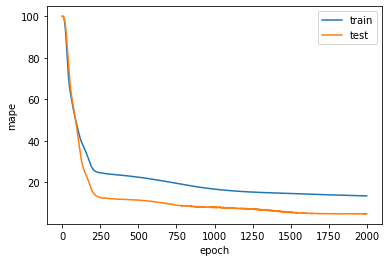

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## **Evaluación del Modelo**



In [23]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model([X_test_num, X_test_bool])
mape = mean_absolute_percentage_error(y_test, y_pred.numpy())

example=pd.read_csv('example_submission.csv', index_col='id')
y_example = scaler_y.transform(example.values) if SCALE_OUTPUT else example.values
mape_example = mean_absolute_percentage_error(y_example, y_pred)

print(mape, mape_example)

0.04947275039185087 0.24642098095980652


In [26]:
y_submission = scaler_y.inverse_transform(y_pred.numpy()) if SCALE_OUTPUT else y_pred.numpy()

output = pd.DataFrame(y_submission, index=test_dummy.index, columns=['valormt2_predicted'])
output.to_csv('Submissions/submission8.csv')

## Referencias

[Google AI Blog: Wide and Deep Learning](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)